# Анализ рекламных событий

Импортируем необходимые библиотеки и посмотрим на данные:

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
data = pd.read_csv('test_data.csv', dtype={'time': np.int64}, parse_dates=['date'])
data.date = data.date.dt.date

In [28]:
data.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1554744145,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1555103458,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1555402601,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1554822479,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1554966717,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


Построим график общего числа событий по дням:

In [29]:
events = data.groupby(['date'], as_index=False).count()[['date', 'event']]

## 1) Воспроизведите график числа рекламных событий по дням 

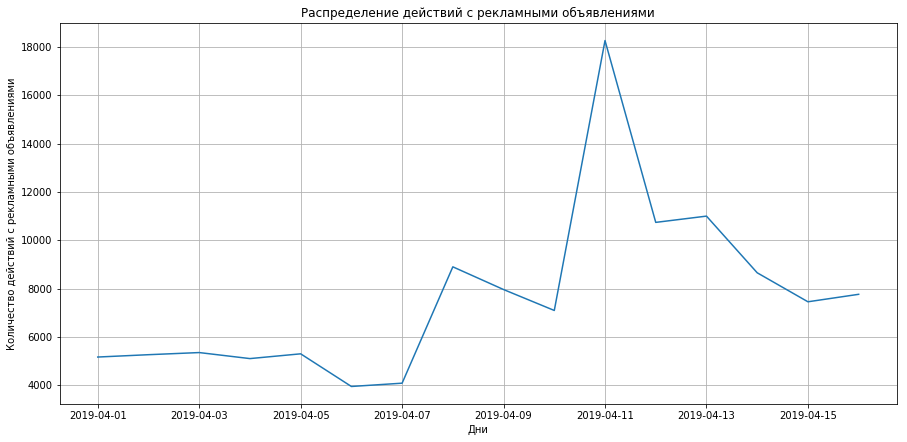

In [30]:
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(events['date'], 
        events['event'])
ax.set(xlabel="Дни",
       ylabel="Количество действий с рекламными объявлениями",
       title="Распределение действий с рекламными объявлениями")
plt.grid()

На графике действительно наблюдается довольно резкий скачок 11го апреля. Чтобы понять причину, исследуем данные более подробно:

In [31]:
# Вначале узнаем какие события есть в принципе, и нет ли опечаток
data.event.unique()

array(['report', 'click', 'view'], dtype=object)

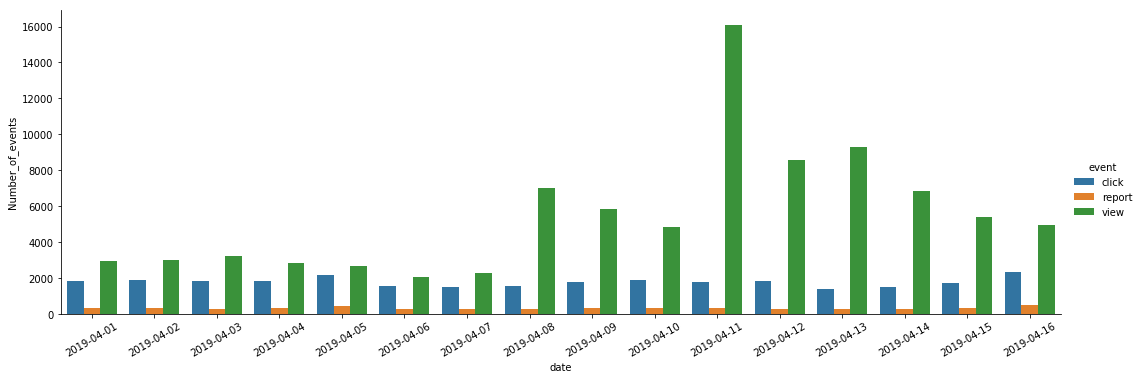

In [32]:
# Построим график соотношения этих событий для каждого дня.
event_type_stat = data.groupby(['date', 'event'], as_index=False)[['time']] \
.count() \
.rename(columns={'time': 'Number_of_events'})

sns.catplot(x='date', y='Number_of_events', hue='event', data=event_type_stat, kind='bar', aspect=3) \
.set_xticklabels(rotation=30)

# Как видно из графика, число событий возросло исключительно за счет показов объявлений

In [33]:
# Проверим соответствует ли даты колонок "time" и "date"
data['datetime'] = pd.to_datetime(data.time, unit='s')
data.loc[data.date != data.datetime.dt.date]

# Несоответствий не обнаружилось

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,datetime


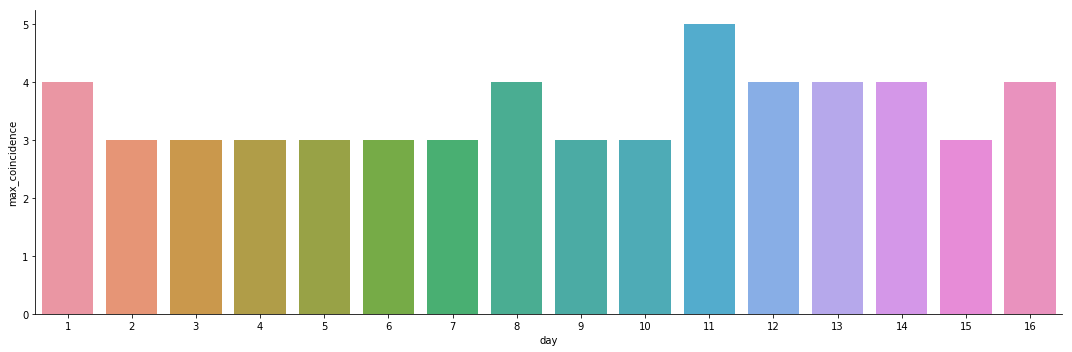

In [34]:
# Посмотрим на количество одинаковых timestamp по дням - на максимальное количество записей с одним и тем же Timestamp
# нет ли скачков, указывающих на ошибку в сборе данных или их дублировании

same_timestamps = data[['time', 'event']] \
.groupby('time', as_index=False) \
.count() \
.rename(columns={'event': 'max_coincidence', 'time': 'day'})

same_timestamps = same_timestamps.loc[same_timestamps.max_coincidence > 1]
same_timestamps['day'] = pd.to_datetime(same_timestamps.day, unit='s').dt.day
same_timestamps = same_timestamps.groupby('day', as_index=False) \
.max()

sns.catplot(x='day', y='max_coincidence', data=same_timestamps, kind='bar', aspect=3) 

# График не показывает резких скачков

In [35]:
# Узнаем максимальное количество объявлений для одной кампании

data[['campaign_union_id', 'ad_id']].drop_duplicates() \
.groupby('campaign_union_id', as_index=False) \
.count() \
.sort_values(by='ad_id', ascending=False).head()

,campaign_union_id,ad_id
5262,campaign_29021,71
4495,campaign_2464,62
375,campaign_105672,42
1267,campaign_112258,29
12192,campaign_98101,26


In [36]:
# Проверим, были ли случаи, когда один рекламный клиент приписывался нескольким рекланым агенствам

data[['agency_union_id', 'client_union_id']].drop_duplicates() \
.groupby('client_union_id', as_index=False) \
.count() \
.sort_values(by='agency_union_id', ascending=False).head()

# Таких случаев не было

,client_union_id,agency_union_id
0,client_1,1
5809,client_32418,1
5803,client_32384,1
5804,client_32385,1
5805,client_32403,1


In [37]:
# Аналогично, проверим были ли случаи, когда одна реклама относилась к нескольким рекланым кампаниям

data[['campaign_union_id', 'ad_id']].drop_duplicates() \
.groupby('ad_id', as_index=False) \
.count() \
.sort_values(by='campaign_union_id', ascending=False).head()

# Таких случаев не было

,ad_id,campaign_union_id
0,ad_1,1
12030,ad_39268,1
12036,ad_39281,1
12035,ad_39279,1
12034,ad_39276,1


Посмотрим на все показы объвлений в этот конкретный день, 11го апреля, 
сгруппируем их по объявлениям, посчитаем количество и узнаем у каких объявлений было 
больше всего показов

In [38]:
views_11_04 = data.loc[(data['date'] == dt.date(2019,4,11)) & (data['event'] == 'view')]

views_11_04.groupby('ad_id', as_index=False) \
.count() \
.sort_values(by=['time'], ascending=False)[['ad_id', 'event']].head()

,ad_id,event
756,ad_49554,9631
757,ad_49556,3454
758,ad_49560,512
759,ad_49564,334
714,ad_388,101


Видно, что у объявления ad_49554 значительно больше показов чем у остальных

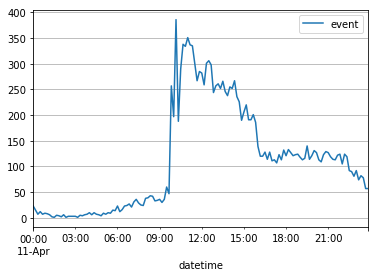

In [39]:
# Посмотрим во сколько именно произошел скачок. Построим график суммарного количества показов за каждые 10 минут

views_11_04[['datetime', 'event']].set_index('datetime').resample("10T").count().plot(grid=True)

In [40]:
# Посмотрим на данные для этого конкретного объявления
ad_49554 = data.loc[data['ad_id'] == 'ad_49554'].reset_index(drop=True)
ad_49554.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,datetime
0,1555169778,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-13,2019-04-13 15:36:18
1,1555251921,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-14,2019-04-14 14:25:21
2,1555011001,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
3,1555061106,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-12,2019-04-12 09:25:06
4,1554977283,view,CPC,0,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03


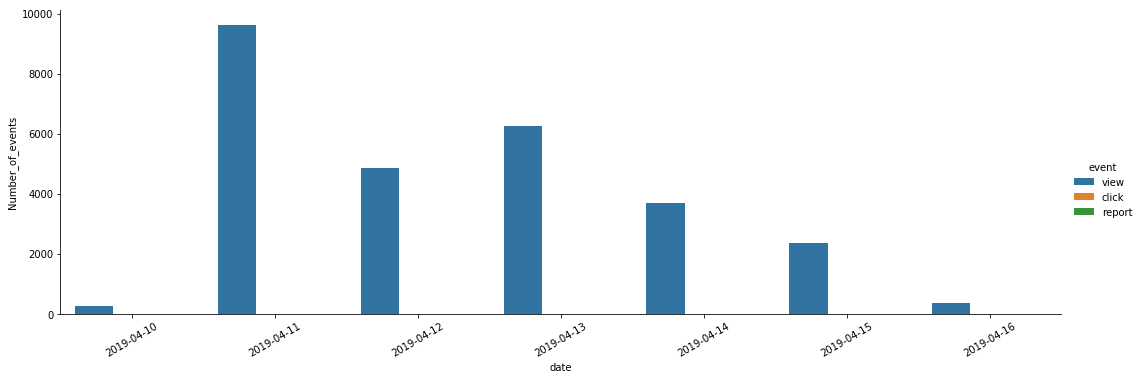

In [41]:
# Посмотрим как для этого объявления выглядит соотношение трех событий по дням
event_type_stat_ad_49554 = ad_49554.groupby(['date', 'event'], as_index=False)[['time']] \
.count() \
.rename(columns={'time': 'Number_of_events'})

sns.catplot(x='date', y='Number_of_events', hue='event', data=event_type_stat_ad_49554, kind='bar', aspect=3) \
.set_xticklabels(rotation=30)

# Видно, что на данное объявление редко нажимают, и, что, вероятно, объявление было опубликовано 10-11 числа,
# так как ранее записей с ним нет

## 2) Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло. 

Вероятнее всего, скачок 11го апреля произошел из-за появления нового объявления, для которого какое-то время экспериментировали с настройками аудитории, и, в какой-то момент она стала слишком широкой. Количество показов в дальнейшем снизилось, так как настройки аудитории были изменены. Скачок можно не считать аномалией.

## 3) Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик

Вновь посмотрим на данные и выделим некоторые колонки в отдельный датафрейм

In [42]:
data.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,datetime
0,1554744145,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57


In [43]:
X = data[['datetime', 'time', 'event', 'ad_cost_type', 'platform', 'agency_union_id', 'has_video']]

Для автоматического определения аномалий можно воспользоваться алгоритмом изолирующего дерева (Isolation Forest). Основная идея данного алгоритма заключается в том, что если некую точку в пространстве характеристик можно изолировать от основоного множества за достаточно малое количество итераций - её можно считать аномалией.

Переведем все характеристики в численное представление. 

In [44]:
X.agency_union_id = X.loc[:, 'agency_union_id'].apply(lambda x: 1 if (x == 'no_agency') else 0)
X = pd.get_dummies(X)
X.head()

C:\Users\margarita.potokina\Anaconda3\envs\coursera_ds\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,datetime,time,agency_union_id,has_video,event_click,event_report,event_view,ad_cost_type_CPC,ad_cost_type_CPM,platform_android,platform_iphone,platform_mvk,platform_web,platform_wphone
0,2019-04-08 17:22:25,1554744145,1,0,0,1,0,0,1,1,0,0,0,0
1,2019-04-12 21:10:58,1555103458,1,0,1,0,0,0,1,1,0,0,0,0
2,2019-04-16 08:16:41,1555402601,1,0,1,0,0,0,1,0,0,0,1,0
3,2019-04-09 15:07:59,1554822479,1,0,1,0,0,0,1,1,0,0,0,0
4,2019-04-11 07:11:57,1554966717,1,0,1,0,0,0,1,0,0,0,1,0


Нам нужно посчитать число совпадений для каждого Timestamp. Для этого сгруппируем по времени, введем колонку совпадений и для каждой группы вычислим сумму

In [45]:
X['coincidence'] = 1
X = X.groupby('time', as_index=False).sum()

Чтобы анализировать данные за каждый день, необходимо разбить имеющиеся данные по дням. Для каждого дня будем анализировать не само число событий или количество объявлений на разных платформах, а их долю от общего числа. Поэтому для каждого дня найдем сумму. 
Для количества совпадений нас будет интересовать максимальное значение, а для агенств - только доля объявлений от физических лиц.

In [46]:
X['datetime'] = pd.to_datetime(X.time, unit='s')
X = X.set_index('datetime').resample("D") \
.agg({'coincidence': 'max',
     'agency_union_id': ['sum', 'count'],
     'has_video': ['sum', 'count'],
     'event_click': 'sum',
     'event_report': 'sum',
     'event_view': 'sum',
     'ad_cost_type_CPC': 'sum',
     'ad_cost_type_CPM': 'sum',
     'platform_android': 'sum',
     'platform_iphone': 'sum',
     'platform_mvk': 'sum',
     'platform_web': 'sum',
     'platform_wphone': 'sum'})

In [47]:
X.head()

coincidence agency_union_id       has_video       event_click  \
                   max             sum count       sum count         sum   
datetime                                                                   
2019-04-01           4            3339  5000        60  5000      1827.0   
2019-04-02           3            3435  5084        53  5084      1898.0   
2019-04-03           3            3350  5141        52  5141      1837.0   
2019-04-04           3            3316  4911        55  4911      1871.0   
2019-04-05           3            3472  5099        44  5099      2188.0   

           event_report event_view ad_cost_type_CPC ad_cost_type_CPM  \
                    sum        sum              sum              sum   
datetime                                                               
2019-04-01        362.0     2983.0           1866.0           3306.0   
2019-04-02        366.0     3005.0           1786.0           3483.0   
2019-04-03        304.0     3216.0           2005.0           3352.0   
2019-04-04        368.0     2869.0           1975.0           3133.0   
2019-04-05        432.0     2685.0           1947.0           3358.0   

           platform_android platform_iphone platform_mvk platform_web  \
                        sum             sum          sum          sum   
datetime                                                                
2019-04-01           3411.0           750.0        255.0        733.0   
2019-04-02           3446.0           807.0        275.0        717.0   
2019-04-03           3482.0           875.0        251.0        736.0   
2019-04-04           3343.0           813.0        235.0        695.0   
2019-04-05           3491.0           827.0        309.0        656.0   

           platform_wphone  
                       sum  
datetime                    
2019-04-01              23  
2019-04-02              24  
2019-04-03              13  
2019-04-04              22  
2019-04-05              22

Теперь создадим тренировочный датафрейм и заполним его колонками с вычесленными соотношениями.

In [48]:
X_train = pd.DataFrame()

In [49]:
X_train['coincidence'] = X.coincidence['max']

X_train['agency_union_id'] = X.agency_union_id['sum'] / X.agency_union_id['count']

X_train['has_video'] = X.has_video['sum'] / X.has_video['count']

X_train['event_click'] = X.event_click['sum'] / (X.event_click['sum'] + X.event_report['sum'] + X.event_view['sum'])
X_train['event_report'] = X.event_report['sum'] / (X.event_click['sum'] + X.event_report['sum'] + X.event_view['sum'])
X_train['event_view'] = X.event_view['sum'] / (X.event_click['sum'] + X.event_report['sum'] + X.event_view['sum'])

X_train['ad_cost_type_CPC'] = X.ad_cost_type_CPC['sum'] / (X.ad_cost_type_CPC['sum'] + X.ad_cost_type_CPM['sum'])
X_train['ad_cost_type_CPM'] = X.ad_cost_type_CPM['sum'] / (X.ad_cost_type_CPC['sum'] + X.ad_cost_type_CPM['sum'])

X_train['platform_android'] = X.platform_android['sum'] / (X.platform_android['sum'] \
                                                          + X.platform_iphone['sum'] \
                                                          + X.platform_mvk['sum'] \
                                                          + X.platform_web['sum'] \
                                                          + X.platform_wphone['sum'])
X_train['platform_iphone'] = X.platform_iphone['sum'] / (X.platform_android['sum'] \
                                                          + X.platform_iphone['sum'] \
                                                          + X.platform_mvk['sum'] \
                                                          + X.platform_web['sum'] \
                                                          + X.platform_wphone['sum'])
X_train['platform_mvk'] = X.platform_mvk['sum'] / (X.platform_android['sum'] \
                                                          + X.platform_iphone['sum'] \
                                                          + X.platform_mvk['sum'] \
                                                          + X.platform_web['sum'] \
                                                          + X.platform_wphone['sum'])
X_train['platform_web'] = X.platform_web['sum'] / (X.platform_android['sum'] \
                                                          + X.platform_iphone['sum'] \
                                                          + X.platform_mvk['sum'] \
                                                          + X.platform_web['sum'] \
                                                          + X.platform_wphone['sum'])
X_train['platform_wphone'] = X.platform_wphone['sum'] / (X.platform_android['sum'] \
                                                          + X.platform_iphone['sum'] \
                                                          + X.platform_mvk['sum'] \
                                                          + X.platform_web['sum'] \
                                                          + X.platform_wphone['sum'])

In [50]:
X_train.head()

,coincidence,agency_union_id,has_video,event_click,event_report,event_view,ad_cost_type_CPC,ad_cost_type_CPM,platform_android,platform_iphone,platform_mvk,platform_web,platform_wphone
datetime,,,,,,,,,,,,,
2019-04-01,4,0.667800,0.012000,0.353248,0.069992,0.576759,0.360789,0.639211,0.659513,0.145012,0.049304,0.141725,0.004447
2019-04-02,3,0.675649,0.010425,0.360220,0.069463,0.570317,0.338964,0.661036,0.654014,0.153160,0.052192,0.136079,0.004555
2019-04-03,3,0.651624,0.010115,0.342916,0.056748,0.600336,0.374277,0.625723,0.649991,0.163338,0.046855,0.137390,0.002427
2019-04-04,3,0.675219,0.011199,0.366288,0.072044,0.561668,0.386648,0.613352,0.654464,0.159162,0.046006,0.136061,0.004307
2019-04-05,3,0.680918,0.008629,0.412441,0.081433,0.506126,0.367012,0.632988,0.658058,0.155891,0.058247,0.123657,0.004147


Импортируем необходимую библиотеку и обучим модель.

In [51]:
from sklearn.ensemble import IsolationForest

In [52]:
model = IsolationForest()
model.fit(X_train)

C:\Users\margarita.potokina\Anaconda3\envs\coursera_ds\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\margarita.potokina\Anaconda3\envs\coursera_ds\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

Для настройки параметров модели вероятно необходимы данные от бОльшего количества дней (у нас их 16).

Посмотрим на разброс значений в нашем тренировочном датафрейме и построим тестовый датафрейм, в котором к примеру вдруг случилось 100 совпадений Timestamp.

In [53]:
X_train.describe()

,coincidence,agency_union_id,has_video,event_click,event_report,event_view,ad_cost_type_CPC,ad_cost_type_CPM,platform_android,platform_iphone,platform_mvk,platform_web,platform_wphone
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,3.500000,0.481065,0.006978,0.273854,0.052487,0.673658,0.540489,0.459511,0.673717,0.142551,0.060392,0.120225,0.003115
std,0.632456,0.188446,0.003422,0.102254,0.020302,0.122329,0.173676,0.173676,0.036498,0.026563,0.009141,0.016678,0.001180
min,3.000000,0.174502,0.002075,0.099184,0.019223,0.506126,0.338964,0.157511,0.621209,0.096648,0.046006,0.080553,0.000931
25%,3.000000,0.331843,0.004096,0.176823,0.034404,0.568155,0.376502,0.308241,0.653008,0.116440,0.051913,0.114194,0.002196
50%,3.000000,0.488701,0.006162,0.284681,0.052818,0.658878,0.540224,0.459776,0.658786,0.153950,0.061662,0.124179,0.002993
75%,4.000000,0.662137,0.010192,0.361737,0.070505,0.789836,0.691759,0.623498,0.698832,0.159559,0.068783,0.130066,0.004247
max,5.000000,0.680918,0.012000,0.412441,0.081433,0.881593,0.842489,0.661036,0.747523,0.186700,0.072343,0.141725,0.004644


In [54]:
X_test = pd.DataFrame()
X_test['coincidence'] = [100]
X_test['agency_union_id'] = 0.6
X_test['has_video'] = 0.01
X_test['event_click'] = 0.35
X_test['event_report'] = 0.03
X_test['event_view'] = 0.6
X_test['ad_cost_type_CPC'] = 0.4
X_test['ad_cost_type_CPM'] = 0.6
X_test['platform_android'] = 0.6
X_test['platform_iphone'] = 0.2
X_test['platform_mvk'] = 0.08
X_test['platform_web'] = 0.1
X_test['platform_wphone'] = 0.004

In [55]:
X_test

,coincidence,agency_union_id,has_video,event_click,event_report,event_view,ad_cost_type_CPC,ad_cost_type_CPM,platform_android,platform_iphone,platform_mvk,platform_web,platform_wphone
0,100,0.6,0.01,0.35,0.03,0.6,0.4,0.6,0.6,0.2,0.08,0.1,0.004


In [56]:
y = model.predict(X_test)
y

C:\Users\margarita.potokina\Anaconda3\envs\coursera_ds\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


array([-1])

Как можно видеть, аномалия определилась.

Ежедневно поступающие данные можно аналогичным способом обрабатывать и, используя модель, проверять на аномалии. Периодически, модель можно дообучать, по мере накопления данных.


Для иных временных интервалов (1 час, 5 минут, ...), можно поступить аналогичным способом, разбив данные на соответствующие отрезки. Однако, стоит учесть часовой пояс, в котором показывают объявление, и ввести некий параметр, в котором будут учитываться ночные и дневные часы, так как данные вероятно будут сильно разниться.